In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv("/content/PJME_hourly.csv")
pjme = pjme.set_index('Datetime')
pjme.index = pd.to_datetime(pjme.index)

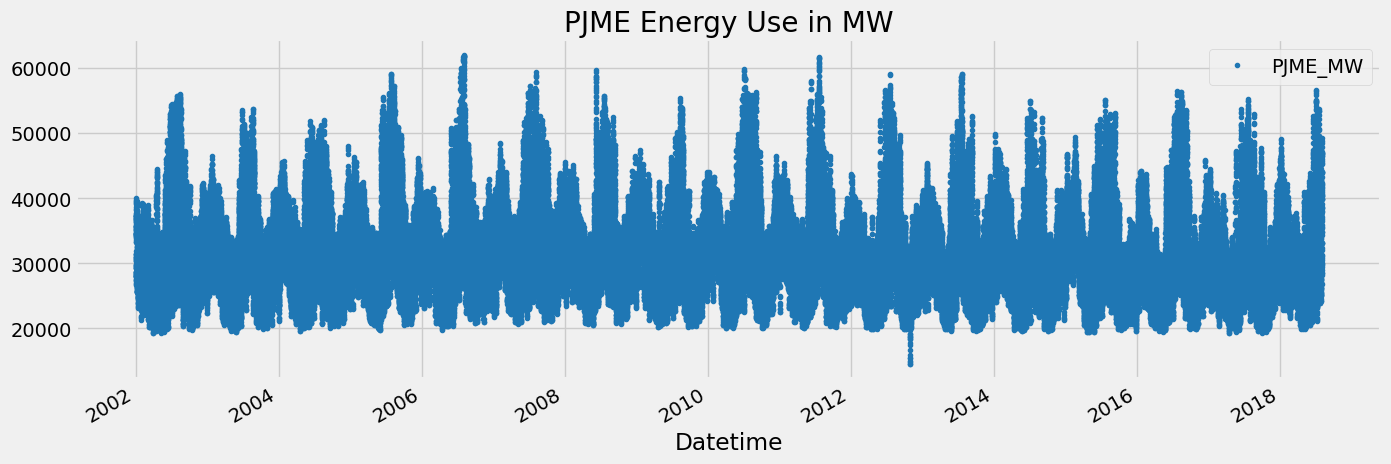

In [3]:
pjme.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

<Axes: ylabel='Frequency'>

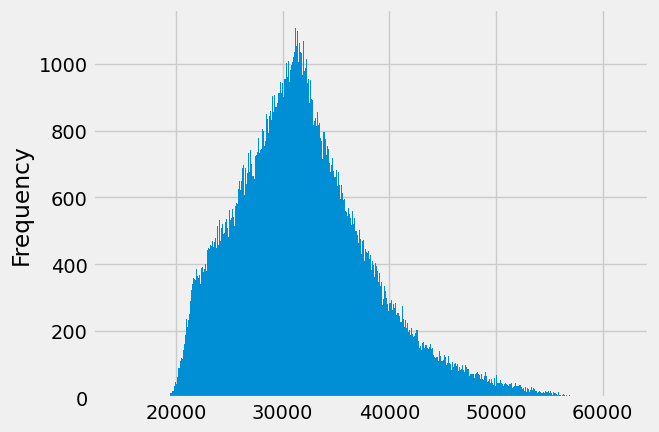

In [4]:
pjme['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

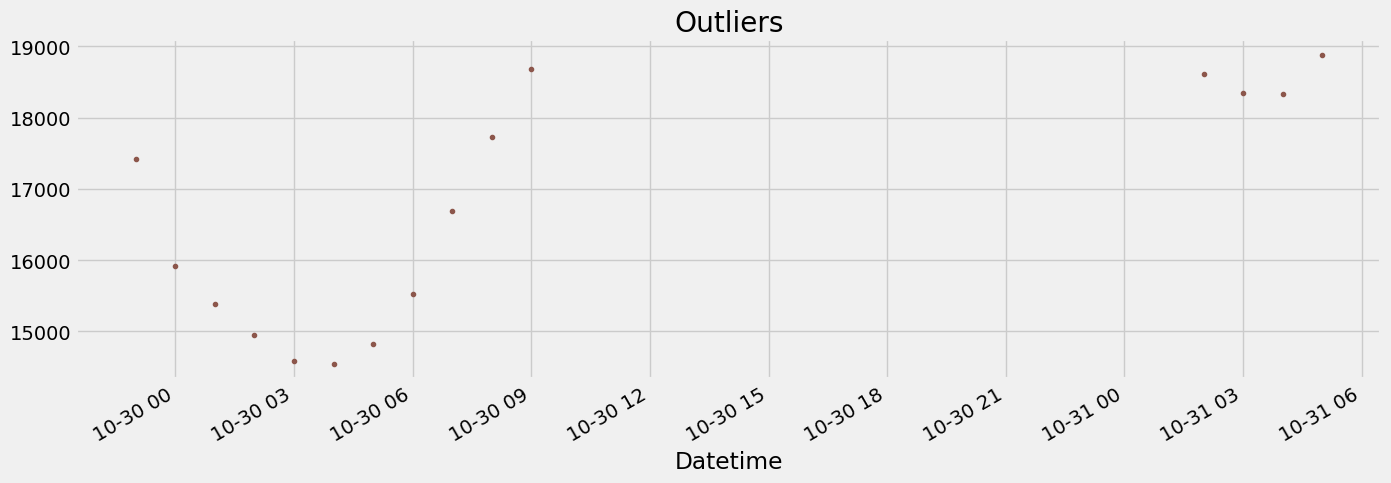

In [5]:
pjme.query('PJME_MW < 19000')['PJME_MW'].plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')


In [6]:
print(pjme.isnull().sum())
print(pjme.duplicated().sum())
print(pjme.shape)
print(pjme.info())
print(pjme.describe())
print(np.isinf(pjme).sum())

PJME_MW    0
dtype: int64
116925
(145366, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None
             PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000
PJME_MW    0
dtype: int64


In [7]:
# new dataset without outlayers
pjme = pjme.query('PJME_MW > 19_000').copy()

## *Train/Test*

Training set shape: (113911, 1)
Testing set shape: (31440, 1)
Percentage of data in training set: 78.37 %
Percentage of data in testing set: 21.63 %


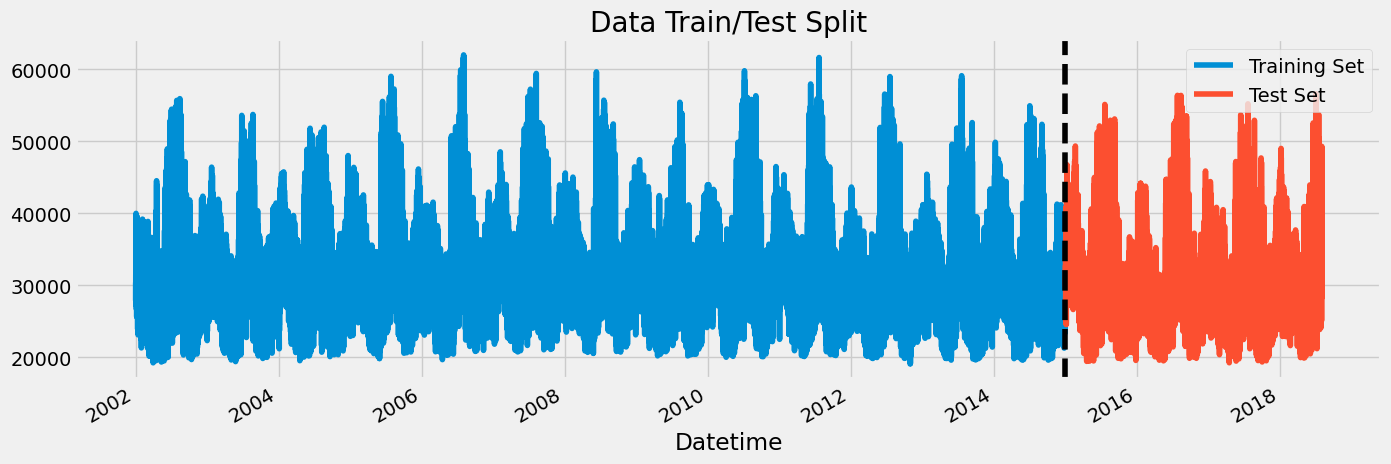

In [8]:
train = pjme.loc[pjme.index < '01-01-2015']
test = pjme.loc[pjme.index >= '01-01-2015']
# Check the shape of the training and testing sets
print("Training set shape:", train.shape)
print("Testing set shape:", test.shape)

# Checking for bias in the split
train_pct = len(train) / len(pjme) * 100
test_pct = len(test) / len(pjme) * 100
print("Percentage of data in training set:", round(train_pct, 2), '%')
print("Percentage of data in testing set:", round(test_pct, 2), '%')
# plot
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# *TSCV*

In [17]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
pjme = pjme.sort_index()

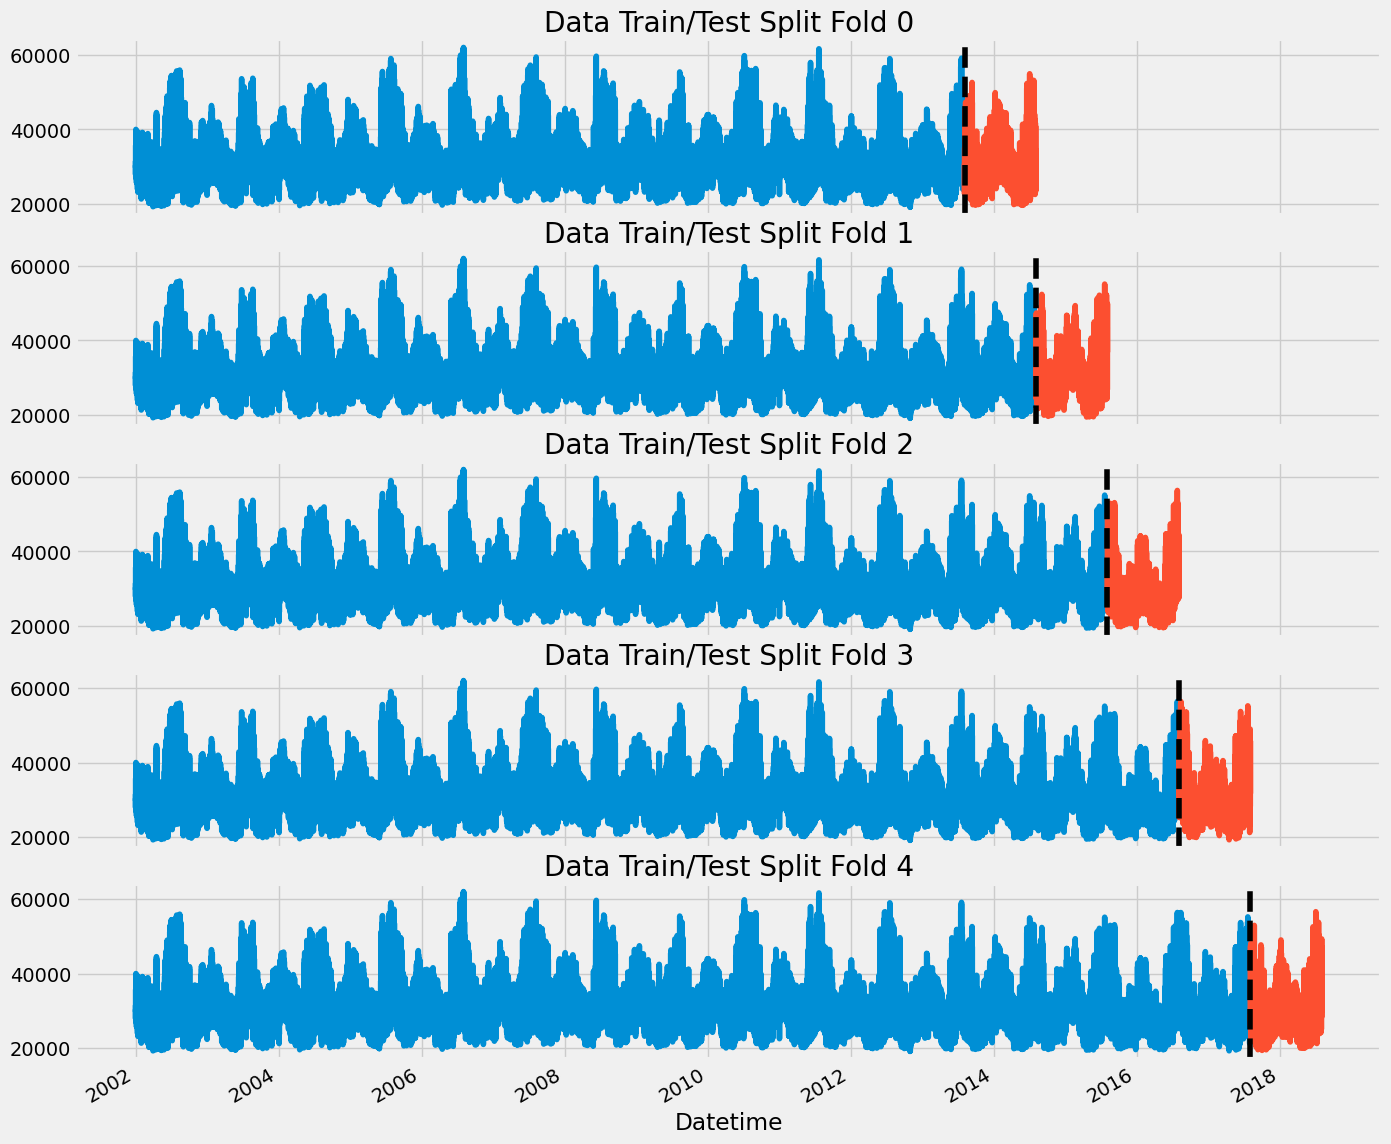

In [18]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(pjme):
    train = pjme.iloc[train_idx]
    test = pjme.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# *Forecasting Horizon Explained*

In [12]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

pjme = create_features(pjme)

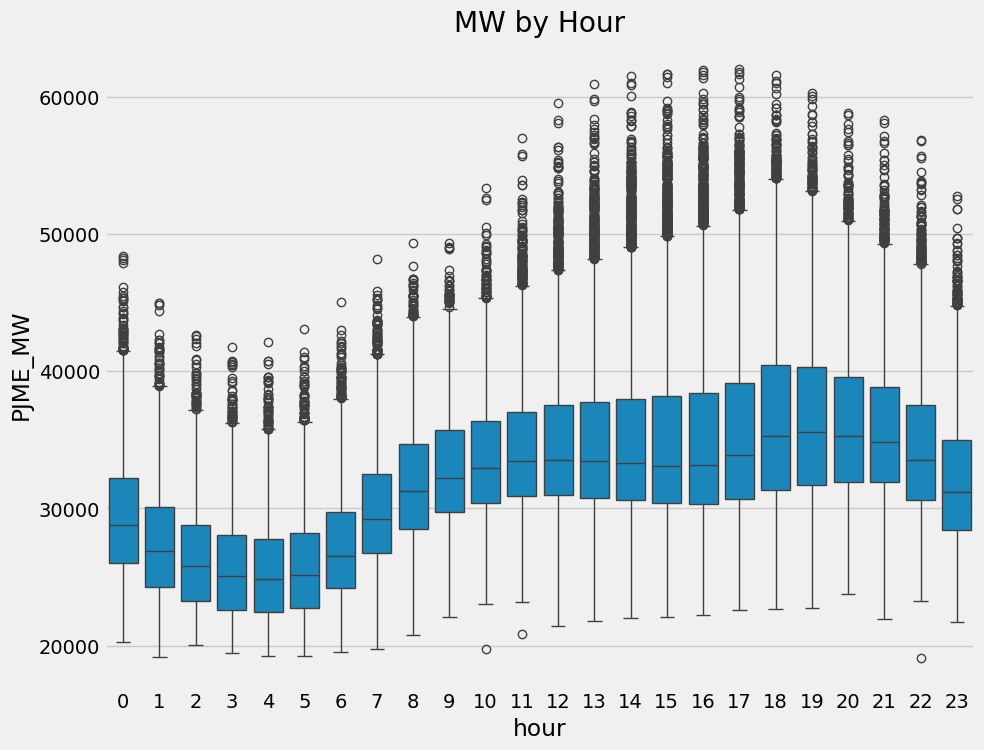

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=pjme, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

<ipython-input-16-4c71da300777>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pjme, x='month', y='PJME_MW', palette='Blues')


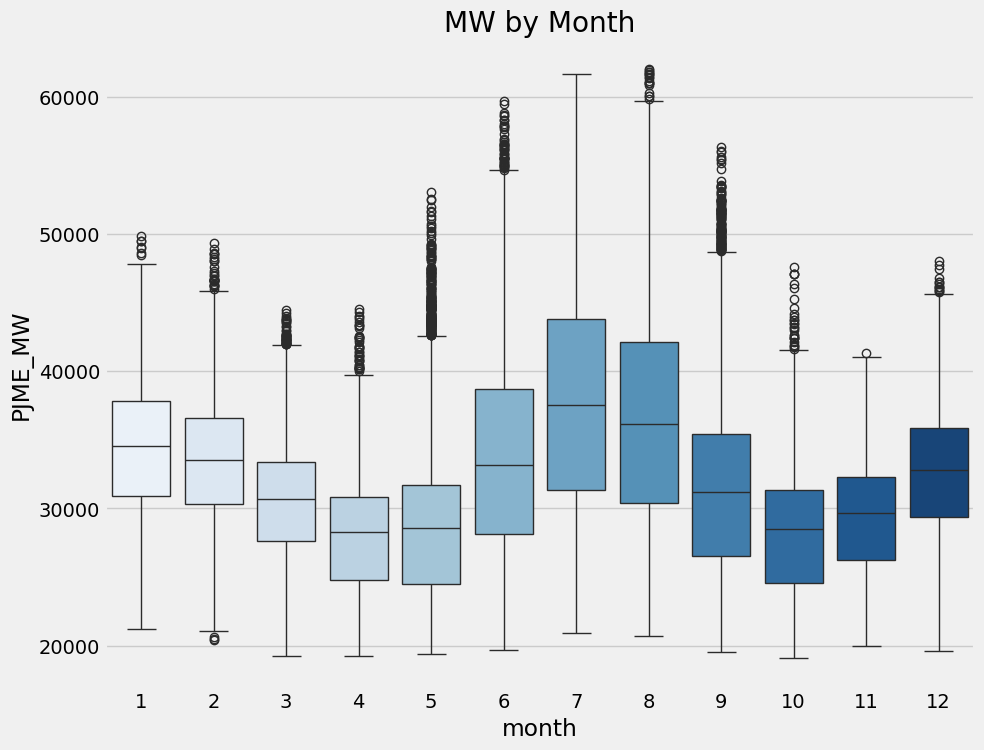

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=pjme, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [19]:
# # Create yearly, quarterly, and decade summaries of the data
# pjme_yearly_sum = pjme.resample('A').mean()
# pjme_yearly_sum.plot()
# plt.title('Avg Gold Price per Year since (year) 1950')
# plt.xlabel('Year')
# plt.ylabel('Price')
# plt.grid()

# pjme_quarterly_sum = pjme.resample('Q').mean()
# pjme_quarterly_sum.plot()
# plt.title('Avg Energy Consumption (quarter)')
# plt.xlabel('Quarter')
# plt.ylabel('Consumption')
# plt.grid()

# pjme_decade_sum = pjme.resample('10Y').mean()
# pjme_decade_sum.plot()
# plt.title('Avg Energy Consumption (decade)')
# plt.xlabel('Decade')
# plt.ylabel('Consumption')
# plt.grid()

The first few rows of the coefficient of variation data:
                  Mean     hour_x  dayofweek_x  quarter_x   month_x  year_x  \
Datetime                                                                      
2002      31565.617106  11.503369     2.994062   2.509649  6.526550  2002.0   
2003      31698.758621  11.502055     2.996575   2.509477  6.525919  2003.0   
2004      32270.434867  11.502050     3.002050   2.505352  6.513550  2004.0   
2005      33310.478648  11.502055     3.004796   2.509477  6.525919  2005.0   
2006      32409.269696  11.502055     3.007536   2.509477  6.525919  2006.0   

          dayofyear_x  dayofmonth_x  weekofyear_x          Std    hour_y  \
Datetime                                                                   
2002       183.017243     15.721937     26.432568  6608.598233  6.921335   
2003       182.996689     15.720484     26.429664  6034.248413  6.922032   
2004       183.496242     15.756434     27.070599  6047.557791  6.922032   
2005     

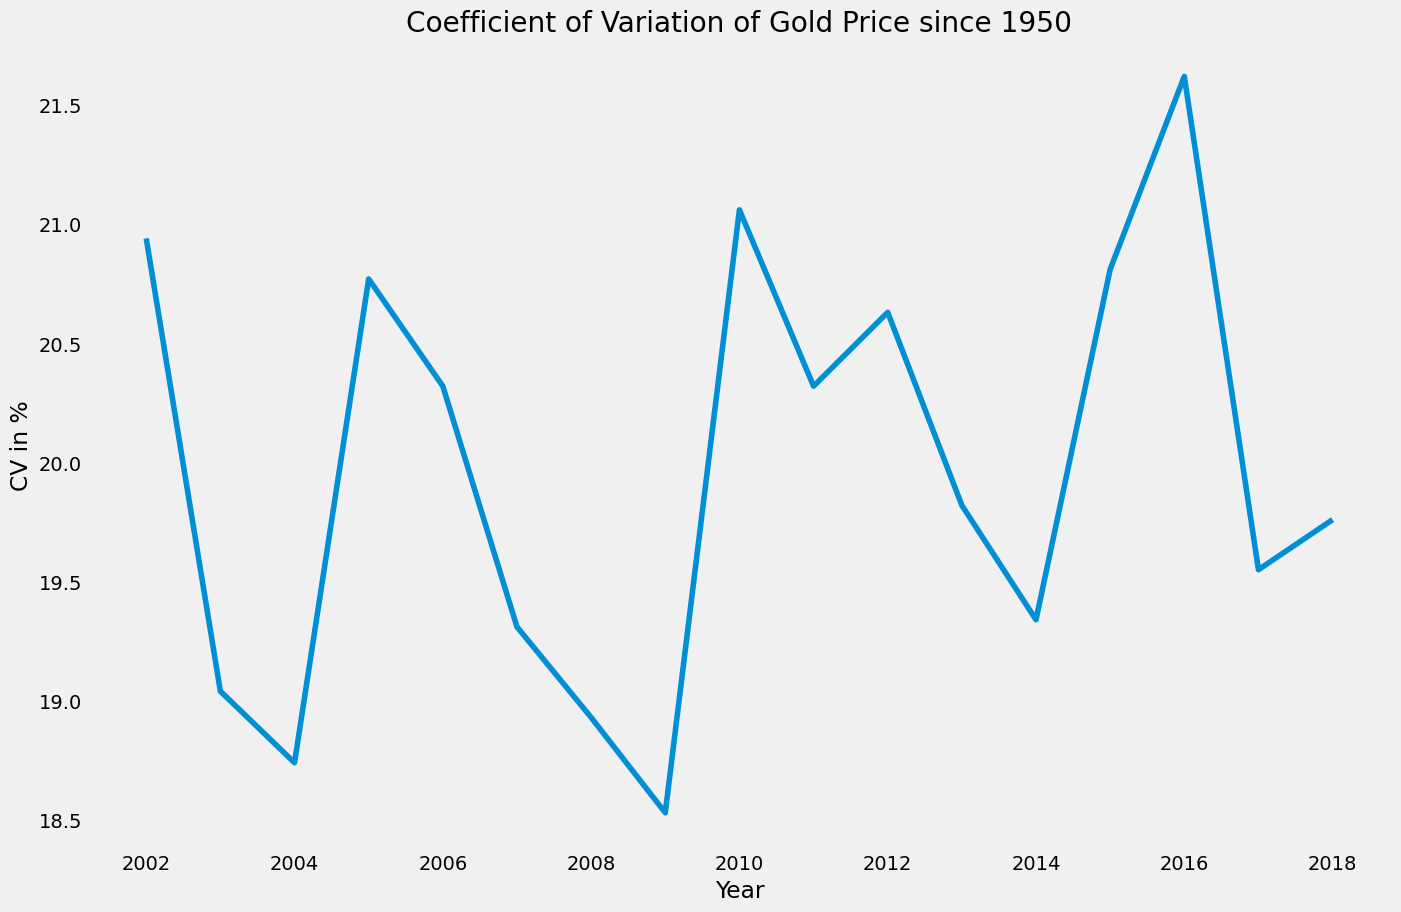

In [20]:
# Calculate the mean, standard deviation, and coefficient of variation (CV) for the data by year
pjme_1 = pjme.groupby(pjme.index.year).mean().rename(columns={'PJME_MW':'Mean'})
pjme_1 = pjme_1.merge(pjme.groupby(pjme.index.year).std().rename(columns={'PJME_MW':'Std'}), left_index=True, right_index=True)
pjme_1['Cov_pct'] = ((pjme_1['Std'] / pjme_1['Mean']) * 100).round(2)

# Plot the CV over time
fig, ax = plt.subplots(figsize=(15, 10))
pjme_1['Cov_pct'].plot()
plt.title('Coefficient of Variation of Gold Price since 1950')
plt.xlabel('Year')
plt.ylabel('CV in %')
plt.grid()
# Display the first few rows of the data
print('The first few rows of the coefficient of variation data:')
print(pjme_1.head())

# *lag features*

In [21]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [22]:
pjme = add_lags(pjme)

# ***Model***

### *train use cross valdation*

In [23]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
pjme = pjme.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(pjme):
    train = pjme.iloc[train_idx]
    test = pjme.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[442]	validation_0-rmse:3369.34730	validation_1-rmse:3764.82810
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.25535
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.56538
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.01446
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.23557
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.12690
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.46154
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4052.57120
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[440]	validation_0-rmse:3479.88018	validation_1-rmse:4011.05271


In [24]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3742.5833
Fold scores:[3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


### *Predicting the Future*


In [25]:
#Retraining on all data
#To Predict the future we need an emtpy dataframe for future date ranges.
#Run those dates through our feature creation code + lag creation

# Retrain on all data
pjme = create_features(pjme)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = pjme[FEATURES]
y_all = pjme[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [26]:
pjme.index.max()

Timestamp('2018-08-03 00:00:00')

In [27]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_pjme = pd.DataFrame(index=future)
future_pjme['isFuture'] = True
pjme['isFuture'] = False
pjme_and_future = pd.concat([pjme, future_pjme])
pjme_and_future = create_features(pjme_and_future)
pjme_and_future = add_lags(pjme_and_future)

In [28]:
future_w_features = pjme_and_future.query('isFuture').copy()

In [29]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

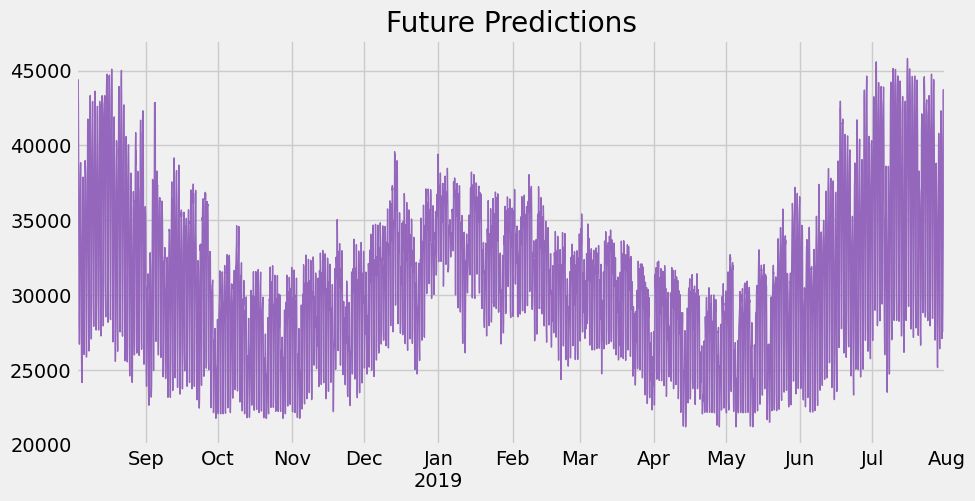

In [30]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

### *Bonus: Saving Model For later*

In [31]:
# Save model
reg.save_model('model.h5')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:56] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [32]:
!ls -lh

total 4.5M
-rw-r--r-- 1 root root 2.4K Sep 25 07:25 gold_price_predictions.png
-rw-r--r-- 1 root root 572K Sep 25 07:31 model.h5
-rw-r--r-- 1 root root 3.9M Sep 25 05:19 PJME_hourly.csv
drwxr-xr-x 1 root root 4.0K Sep 23 13:20 sample_data


<Axes: title={'center': 'Future Predictions'}>

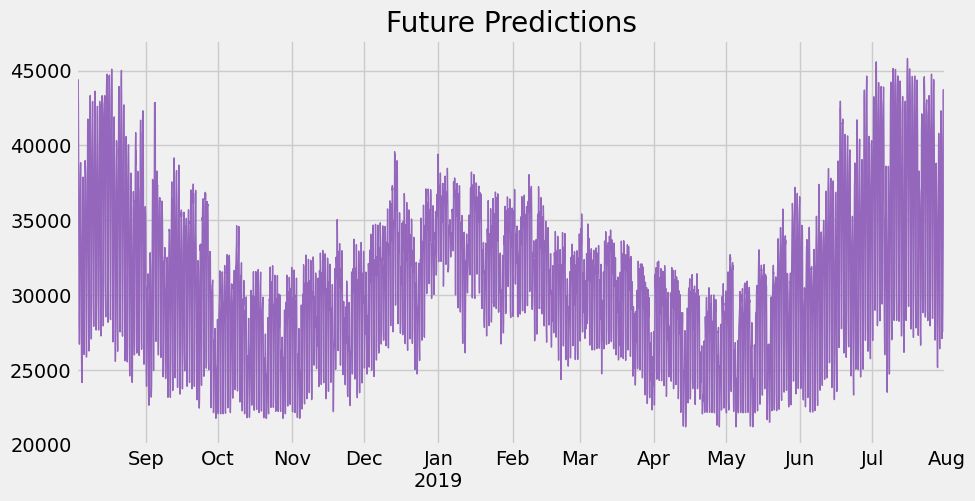

In [33]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.h5')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

In [ ]:
# Plot actual and predicted values with confidence intervals
axis = pjme.plot(label='Actual', figsize=(15,9))
future_w_features['pred'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(future_w_features.index, future_w_features['pred'], future_w_features['pred'], color='m', alpha=0.5)
axis.set_xlabel('Year-Month')
axis.set_ylabel('Energy Consumption')
plt.title('Time Series Prediction on Energy Consumption',fontsize=15)
plt.legend(loc='best')
plt.grid()
plt.show()

# Save plot as png
plt.savefig('gold_price_predictions.png')